In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from Functions import cleanFunctions as cf
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

import random
import itertools
from scipy import interp
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate

In [2]:
'''Function that plots an ROC curve per class of a multiclass classifier case
by using the One Vs Rest technique.  This function was adapted from code
at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
demonstrating the multiclass implementation of ROC curves for classifier
evaluation.

Inputs:
    X_train: dataframe object containing the data to train on.
    y_train: dataframe object containing the label binarized class outputs of 
            the training set.
    X_test: dataframe object containing the data for testing the model
    y_test: dataframe object containing the label binarized class outputs of
            the test set.
    model: classifier object delineating the model to fit
    classes: list containing the classes of the data to be used in plotting

Outputs:
    ROC curve plot containing curves for each class, as well as the micro and
    macro average ROC curves.
'''
def multiclassROC(X_train, y_train, X_test, y_test, model, classes):
    classifier = OneVsRestClassifier(model)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    y_train = label_binarize(y_train, classes=np.unique(y_train))
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_train.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    lw=2
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-av ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-av ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    start = 0.0
    stop = 1.0
    number_of_lines= n_classes
    cm_subsection = np.linspace(start, stop, number_of_lines) 
    colors = [ cm.jet(x) for x in cm_subsection ]
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='Class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Multiclass')
    plt.legend(bbox_to_anchor=(1.00, 1.00))
    plt.show()
    
"""
This function prints and plots the confusion matrix.
Normalization can be applied by setting `normalize=True`.
Adapted from code at: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #bottom, top = plt.ylim() 
    #plt.ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
# Grabbing per game data for players in the 90s
year = np.arange(1990, 2020, 1)
url1 = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"
url2 = "https://www.basketball-reference.com/leagues/NBA_{}_per_minute.html"
url3 = "https://www.basketball-reference.com/leagues/NBA_{}_per_poss.html"
url4 = "https://www.basketball-reference.com/leagues/NBA_{}_advanced.html"
urls = np.array([url1, url2, url3, url4])
stats_year = pd.DataFrame()
stats_raw = pd.DataFrame()
count = 0
for y in year:
    for u in urls:
        print("Progress {:2.1%}".format(count / (len(year)*len(urls))), end="\r")#print progress of paint can position acquisition
        # URL page we will scraping (see image above)
        url = u.format(y)

        # this is the HTML from the given URL
        html = urlopen(url)
        soup = BeautifulSoup(html)

        # use findALL() to get the column headers
        soup.findAll('tr', limit=2)
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        headers
        
        #when concatenating data from each BR page, some duplicate columns are kept, and some columns need
        #to have additional info attached to their labels in order to know that they refer to per 36 or per poss
        #statistics and not per game statistics. The following conditional fix these flaws in the header labels
        if "per_game" in u:
            mystring = "_pg"
            dup = ['Player','Pos','Age','Tm','Year','G','GS']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring
        if "per_minute" in u:
            mystring = "_pm"
            dup = ['Player','Pos','Age','Tm','Year','G']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring
        if "per_poss" in u:
            mystring = "_pp"
            dup = ['Player','Pos','Age','Tm','Year','G']
            for i in range(0, len(headers)):
                if headers[i] not in dup:
                    headers[i] = headers[i] + mystring

        # avoid the first header row
        rows = soup.findAll('tr')[1:]
        player_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]


        stats_new = pd.DataFrame(player_stats, columns = headers)
        if "per_game" not in u:
            stats_new.drop(['Pos', 'Age', 'Tm', 'G'], axis=1)
        [p, s] = stats_new.shape

        stats_year = pd.concat([stats_year, stats_new], axis=1, sort=False)
        count = count + 1
    stats_year.insert (4, "Year", (y*np.ones((p, 1))).astype(int))
    stats_raw = stats_raw.append(stats_year, ignore_index=True)
    stats_year = pd.DataFrame()


stats_raw = stats_raw.drop(['_pp', '\xa0', '\xa0', 'MP_pp', 'MP_pm', 'GS_pp', 'GS_pm'], axis=1)
stats_raw = stats_raw.loc[:,~stats_raw.columns.duplicated()]
stats_raw = stats_raw[~stats_raw['Player'].isnull()]#drop instances where player name is null
stats_raw.head(10)

,Player,Pos,Age,Tm,Year,G,GS,MP_pg,FG_pg,FGA_pg,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Mark Acres,C,27,ORL,1990,80,50,21.1,1.7,3.6,...,17.2,9.4,1.1,0.6,1.6,.047,-3.1,-0.6,-3.7,-0.7
1,Michael Adams,PG,27,DEN,1990,79,74,34.1,5.0,12.5,...,11.1,18.5,4.4,2.5,6.9,.124,1.8,-0.1,1.8,2.6
2,Mark Aguirre,SF,30,DET,1990,78,40,25.7,5.6,11.5,...,10.7,24.3,3.1,2.5,5.7,.136,1.0,0.0,1.0,1.5
3,Danny Ainge,PG,30,SAC,1990,75,68,36.4,6.7,15.4,...,12.7,23.0,2.7,2.1,4.8,.085,1.2,-0.1,1.1,2.1
4,Mark Alarie,PF,26,WSB,1990,82,10,23.1,4.5,9.6,...,10.7,20.4,1.5,1.6,3.1,.079,-0.6,-0.7,-1.3,0.3
5,Steve Alford,PG,25,DAL,1990,41,0,7.4,1.5,3.4,...,9.4,24.7,0.6,0.3,0.9,.144,1.2,0.4,1.6,0.3
6,Randy Allen,SG,25,SAC,1990,63,6,11.8,1.7,3.8,...,9.8,16.5,-0.3,0.6,0.2,.014,-4.2,-0.9,-5.2,-0.6
7,Greg Anderson,PF,25,MIL,1990,60,28,21.5,3.7,7.2,...,13.6,19.1,0.2,1.7,2.0,.073,-2.8,-0.9,-3.8,-0.6
8,Nick Anderson,SG,22,ORL,1990,81,9,22.0,4.6,9.3,...,13.7,22.1,1.2,0.7,1.8,.049,0.0,-1.0,-1.0,0.5
9,Richard Anderson,PF,29,CHH,1990,54,2,11.2,1.6,3.9,...,10.5,17.4,0.4,0.5,1.0,.077,0.6,0.2,0.7,0.4


In [4]:
#data preprocessing
stats_raw.insert(5, 'Decade', stats_raw.loc[:,'Year']%100 // 10)
#for columns known to be numeric, cast to numeric quantities
for c in stats_raw.loc[:, 'Year':].columns.tolist():
    stats_raw.loc[:, c] = pd.to_numeric(stats_raw.loc[:, c])

stats_filt = stats_raw[stats_raw["G"] >= 20]#filter out players who played less than 20 games

#get list of categories in the filtered data set that have null entries after casting to numeric
nulls = [i for i, e in enumerate(stats_filt.isnull().sum().tolist()) if e != 0]
cols = stats_filt.columns.tolist()
null_cats = [cols[i] for i in nulls]

#entries of the filtered dataframe may be null after casting to numeric. check what these specific
#categories describe, in this case the null cats are shooting percentages which likely
#means that a given player did not attempt shots of that type and therfore had a non-numeric (i.e empty)
#string value for their shooting percentage. These instances can be safely imputed as 0.
stats_filt = stats_filt.fillna(0)

#standardize position categories, in the case of multi position players... assign them as their primary position
pos_col = stats_filt.loc[:, 'Pos'].tolist()
for i in range(0, len(pos_col)):
    pos = pos_col[i].split('-')
    pos_col[i] = pos[0]

stats_filt.loc[:, 'Pos'] = pos_col
#move MP to front of data frame (it is a total statistic, not one that can be averaged)
cols = list(stats_filt)
cols.insert(7, cols.pop(cols.index('MP')))#pop the MP column out of its current spot, and reinsert at 7 spot
stats_filt = stats_filt[cols]# use cols list to reorder dataframe columns

#Also, if a player moved team, lets take the averages of the stats from each team, and change team name
#to a concatenated string of the teams played on.
years = stats_filt.loc[:, 'Year'].unique().tolist()#list of years in data set
bp_list = []
count = 0
for y in years:
    print("Progress {:2.1%}".format(count / (len(years))), end="\r")#print progress of paint can position acquisition
    temp = stats_filt[(stats_filt["Year"] == y) & (stats_filt["Tm"] == 'TOT')]#grab instances where a player has a "total" team played for, meaning theyve played for multiple teams in a year
    for p in temp['Player']:#for each player that has played for multiple teams
        pdata = stats_filt[(stats_filt["Year"] == y) & (stats_filt["Player"] == p)]#find the rest of their data from the individual teams for that year
        teams = pdata['Tm'].values.tolist()#get list of teams played for
        if 'TOT' in teams: teams.remove('TOT')#remove "total" team name
        newTm = '/'.join(teams)#join all teams played for seperated by /
        
        indexNames = temp[(temp['Player'] == p) & (temp['Tm'] != 'TOT')].index# Get indexes for player on multiple other teams
        stats_filt.drop(indexNames , inplace=True)# Delete these row indexes from dataFrame
        pidx = stats_filt[stats_filt['Player'] == p].index
        stats_filt.loc[pidx, 'Tm'] = newTm#set Tm name to the concatenated string.
    count = count + 1


print("\n")
print(stats_raw.shape)#shape of original data set
print(stats_filt.shape)#shape after filtering on games played

Progress 96.7%

(16489, 96)
(13076, 96)


(0.5, 55)

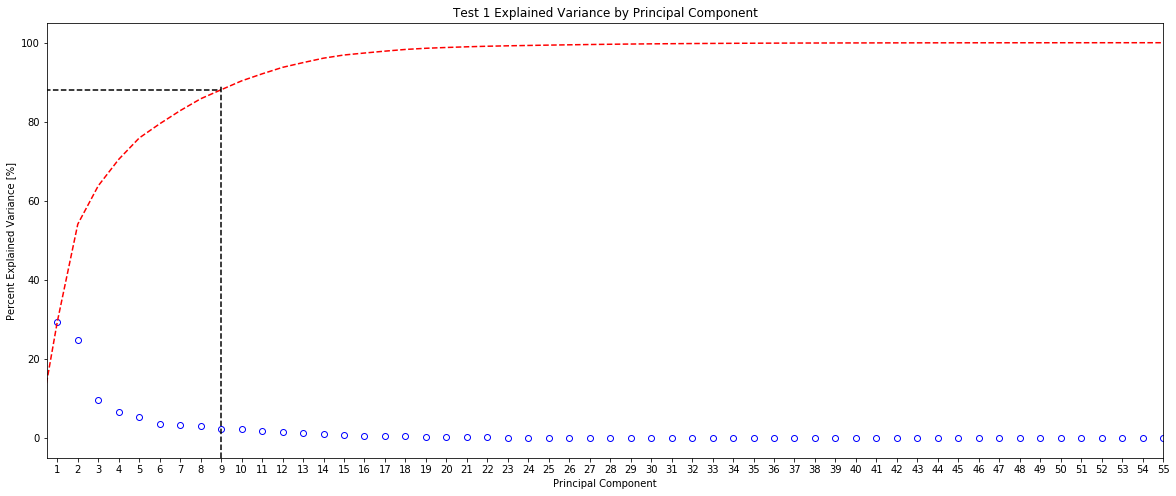

In [5]:
#standardize data before PCA
X = StandardScaler().fit_transform(stats_filt.loc[:, 'MP_pg':'BPM'])

#perform PCA
pca = PCA()
principalComponents = pca.fit_transform(X)
pDf_1 = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
pDf_1['Decade']  = stats_filt['Decade'].tolist()
pDf_1['Pos'] = stats_filt['Pos'].tolist()

percent_explained_var = 100*pca.explained_variance_/sum(pca.explained_variance_)
cut_off = 10
cumulative = 0
cumulative_exp = [0]
required_modes = 0
first_time = True
for i in range(0, len(percent_explained_var)):
    cumulative = cumulative + percent_explained_var[i]
    cumulative_exp.append(cumulative)
    if cumulative > (100 - cut_off) and first_time:
        required_modes = i
        first_time = False
        

f, ax1 = plt.subplots(1, 1, figsize=(20, 8))
ax1.plot(np.arange(0,10,1), cumulative_exp[required_modes]*np.ones(10), 'k--')
ax1.plot(np.arange(1,len(pca.explained_variance_) + 1,1).astype(int), percent_explained_var, 'bo', fillStyle='none')
ax1.plot(np.arange(0,len(pca.explained_variance_) + 1,1).astype(int), cumulative_exp, 'r--')
ax1.axvline(x=required_modes, ymin=0, ymax=cumulative_exp[required_modes-1]/100., c='k', ls = '--')
ax1.set_xticks(np.arange(0,len(pca.explained_variance_) + 1,1)) 
ax1.set_title('Test 1 Explained Variance by Principal Component')
ax1.set_ylabel('Percent Explained Variance [%]')
ax1.set_xlabel('Principal Component')
ax1.set_xlim([0.5, 55])

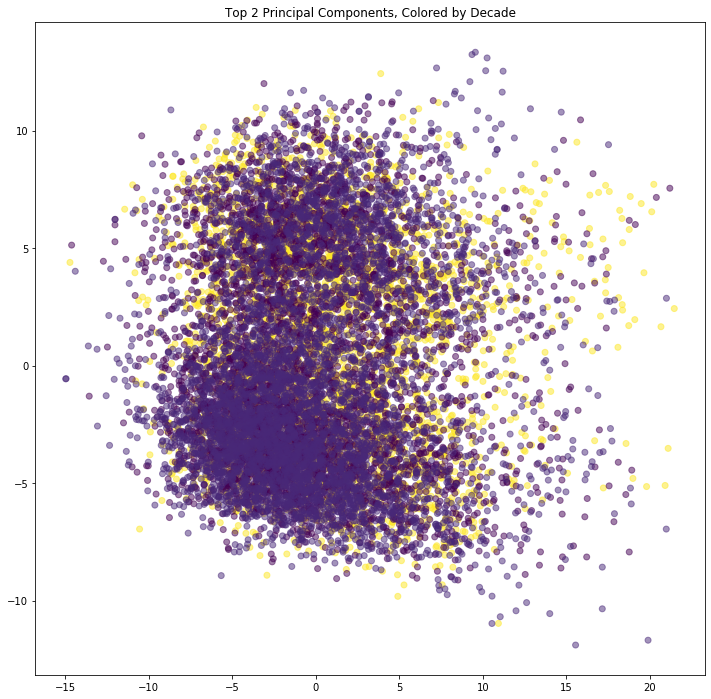

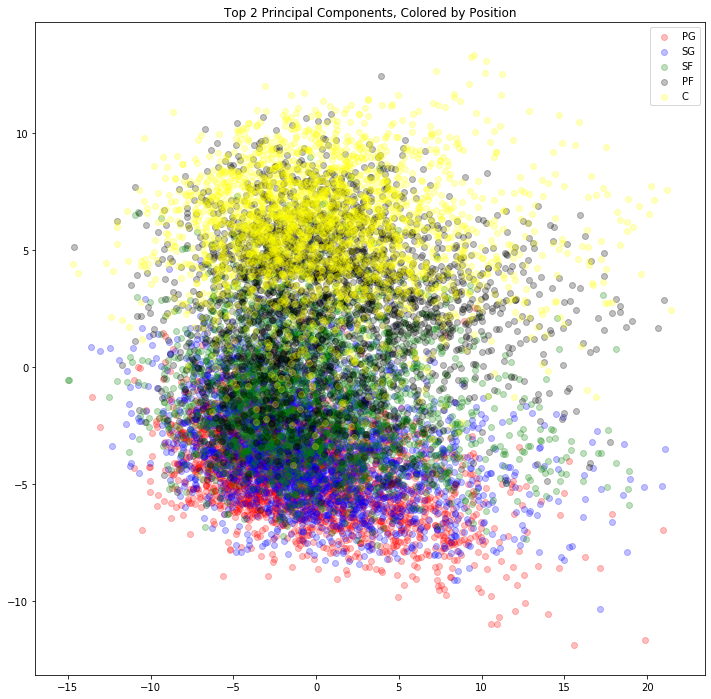

In [6]:
#Top Mode PCA Plots
#first plot colored by decade
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(pDf_1.loc[:,"PC1"], pDf_1.loc[:,"PC2"], alpha=0.5, c=pDf_1.loc[:,'Decade'])
ax.set_title("Top 2 Principal Components, Colored by Decade")

#second plot of principal components colored by position
fig, ax = plt.subplots(figsize=(12, 12))
colors = {'PG':'red', 'SG':'blue', 'SF':'green', 'PF':'black', 'C':'yellow'}
labels = list(colors.keys())
for g in labels:
    ix = pDf_1.index[pDf_1['Pos'] == g]
    ax.scatter(pDf_1.loc[ix, "PC1"], pDf_1.loc[ix, "PC2"], alpha=0.25, c = colors[g], label = g)
ax.set_title("Top 2 Principal Components, Colored by Position")
ax.legend()
ax.legend(labels)

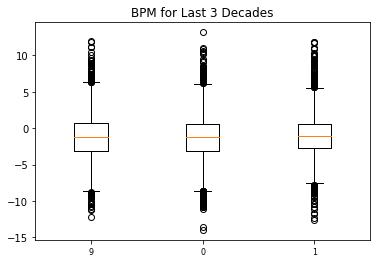

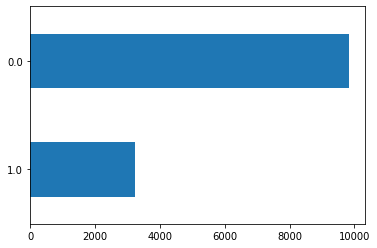

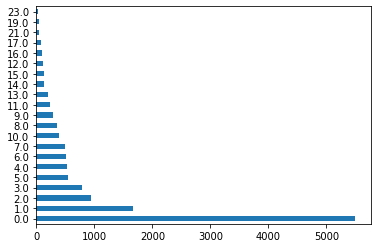

In [7]:
'''Our plan is to split the data set into each decade and first apply PCA to reduce the dimensions of the data 
of each decade. Then we intend to apply ICA to search for statistically independent signals within the data. 
Our hope is to compare the ICA extracted features between eras to demonstrate the dynamics of the sport over the 
last 30 years. If successful, we are also interested in using these feature dynamics to predict the trajectory of 
the sport in the coming decade, and potentially predict new player success.
'''
#We are at some point going to need a metric for predicting success... I propose "years in top 25% of league BPM"
#Lets look at BPM distributions of each decade...
decades = stats_filt.loc[:, 'Decade'].unique().tolist()
bp_list = []
for d in decades:
    temp = stats_filt[stats_filt["Decade"] == d]
    bp_list.append(temp.loc[:, 'BPM'])

#filter out players who played less than 20 games
fig, ax = plt.subplots()
ax.set_title('BPM for Last 3 Decades')
ax.boxplot(bp_list)
ax.set_xticklabels(decades, fontsize=8)
plt.show()

#Let's calculate years in top 25% BPM for each player...
#start by calculating percentile of each player's BPM for each year
years = stats_filt.loc[:, 'Year'].unique().tolist()#list of years in data set
percentile_cutoff = 75.0
bpm_list = []
stats_filt['BPM_annual_percentile'] = np.nan #initialize empty column for holding annual BPM percentile
stats_filt['BPM_class'] = np.nan #initialize empty column for holding BPM class (is top 25% or not?)
count = 0
for y in years:
    print("Progress {:2.1%}".format(count / (len(years))), end="\r")#print progress
    temp = stats_filt[stats_filt["Year"] == y].loc[:, ['Player', 'BPM']]#grab out Player name and BPM data for each year
    for p in temp['Player']:
        playerBPM = temp.loc[temp[temp['Player'] == p].index, 'BPM']#get the player's BPM for the year
        percentile = stats.percentileofscore(temp['BPM'], playerBPM.iloc[0])#calculate what percentile the player's BPM is
        pidx = stats_filt[(stats_filt['Player'] == p) & (stats_filt["Year"] == y)].index#get index of player for the year in full dataset
        stats_filt.loc[pidx,'BPM_annual_percentile'] = percentile#fill in player's BPM percentile value for the year
        if percentile > percentile_cutoff:#check if the percentile is above the cutoff
            stats_filt.loc[pidx,'BPM_class'] = 1#if the player has a BPM percentile higher than cutoff, class 1
        else:
            stats_filt.loc[pidx,'BPM_class'] = 0#otherwise, class 0
    count = count + 1

stats_filt.BPM_class.value_counts().sort_values().plot(kind = 'barh')#counts of BPM classes
plt.show()

#determine years of top 25% BPM performance
stats_filt['BPM_years'] = np.nan
players = stats_filt['Player'].unique().tolist()
count = 0
for p in players:
    print("Progress {:2.1%}".format(count / (len(players))), end="\r")#print progress
    pidx = stats_filt[stats_filt['Player'] == p].index
    p_BPM_count = stats_filt.loc[pidx,'BPM_class'].sum()
    stats_filt.loc[pidx, 'BPM_years'] = p_BPM_count
    count = count + 1
    
stats_filt.BPM_years.value_counts().plot(kind = 'barh')#counts of BPM classes
plt.show()

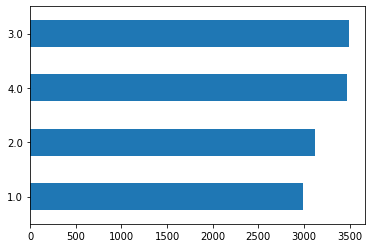

In [8]:
#Instead of BPM.. let's calculate years in top 25% WS for each player...
#start by calculating percentile of each player's WS for each year
years = stats_filt.loc[:, 'Year'].unique().tolist()#list of years in data set
percentile_cutoff = 75.0
bpm_list = []
stats_filt['WS_annual_percentile'] = np.nan #initialize empty column for holding annual BPM percentile
stats_filt['WS_class'] = np.nan #initialize empty column for holding BPM class (is top 25% or not?)
count = 0
for y in years:
    print("Progress {:2.1%}".format(count / (len(years))), end="\r")#print progress
    temp = stats_filt[stats_filt["Year"] == y].loc[:, ['Player', 'WS']]#grab out Player name and BPM data for each year
    for p in temp['Player']:
        playerWS = temp.loc[temp[temp['Player'] == p].index, 'WS']#get the player's WS for the year
        percentile = stats.percentileofscore(temp['WS'], playerWS.iloc[0])#calculate what percentile the player's WS is
        pidx = stats_filt[(stats_filt['Player'] == p) & (stats_filt["Year"] == y)].index#get index of player for the year in full dataset
        stats_filt.loc[pidx,'WS'] = percentile#fill in player's WS percentile value for the year
        if percentile > 75.0:#check if the percentile is above the cutoff
            stats_filt.loc[pidx,'WS_class'] = 4#if the player has a WS percentile higher than cutoff, class 4
        elif percentile > 50.0:
            stats_filt.loc[pidx,'WS_class'] = 3#if the player has a WS percentile higher than cutoff, class 3
        elif percentile > 25.0:
            stats_filt.loc[pidx,'WS_class'] = 2#if the player has a WS percentile higher than cutoff, class 2
        else:
            stats_filt.loc[pidx,'WS_class'] = 1#otherwise, class 1
    count = count + 1

stats_filt.WS_class.value_counts().sort_values().plot(kind = 'barh')#counts of BPM classes
plt.show()

In [10]:
#Data for classification
#everything, no advanced
basic_drop = ['Player', 'Pos','Age','Tm','Year','G','MP','GS','OWS','DWS','WS','WS/48',
              'BPM_annual_percentile','BPM_class','BPM_years','WS_annual_percentile','WS_class']
X_e = stats_filt.drop(basic_drop, axis=1)
#per game only
keep = X_e.columns.tolist()[0:24]
X_pgo = X_e[keep]
#per36
keep = X_e.columns.tolist()[24:45]
keep.append('Decade')
X_pm = X_e[keep]
#per100 pos
keep = X_e.columns.tolist()[45:68]
keep.append('Decade')
X_pp = X_e[keep]
#only advanced stats (no win shares)
keep = X_e.columns.tolist()[68:80]
keep.append('Decade')
X_as = X_e[keep]




Logistic regression classifier: All Stats



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


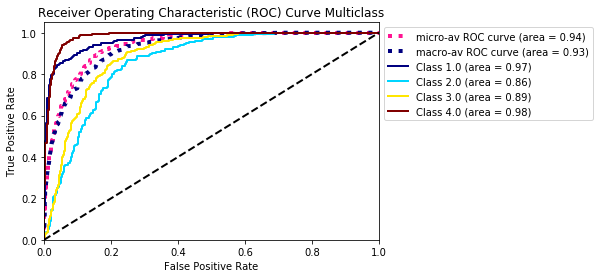

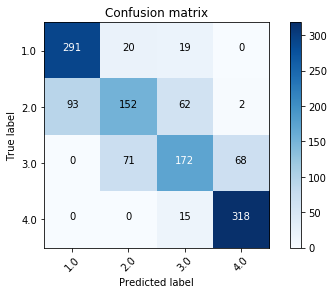

            Results
Accuracy   0.727202
Precision  0.713860
Recall     0.727202
F1         0.715262


Text(0.5, 0, 'Cross Validation Run')

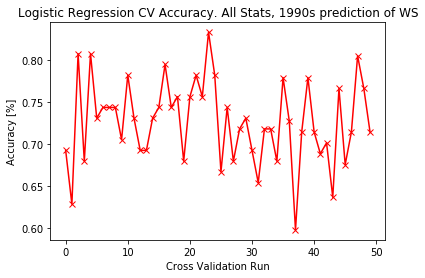

In [34]:
#Implement classification method, all stats, decade 9
decade = 9
X = X_e[X_e['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']
rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: All Stats\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr_e = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr_e)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr_e)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr_e, average='weighted')#get precision
R = recall_score(y_test, preds_logr_e, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr_e, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores_allstats = cross_validate(clf, X, y, cv=50, scoring=scoring)
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,len(scores_allstats['test_accuracy']),1).astype(int), scores_allstats['test_accuracy'], 'r-x')
ax.set_title('Logistic Regression CV Accuracy. All Stats, 1990s prediction of WS')
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Cross Validation Run')




Logistic regression classifier: Per Game



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


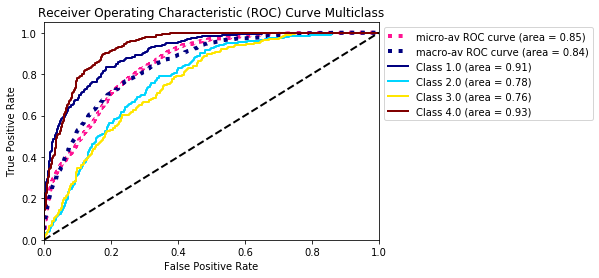

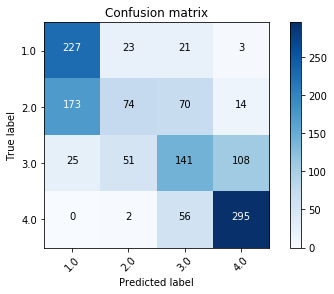

            Results
Accuracy   0.574435
Precision  0.558610
Recall     0.574435
F1         0.544622


In [20]:
#Implement classification method, per game stats, decade 9
decade = 9
X = X_pgo[X_pgo['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']
rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: Per Game\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scores_pg = cross_validate(clf, X, y, cv=50, scoring=scoring)




Logistic regression classifier: Per Minute



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


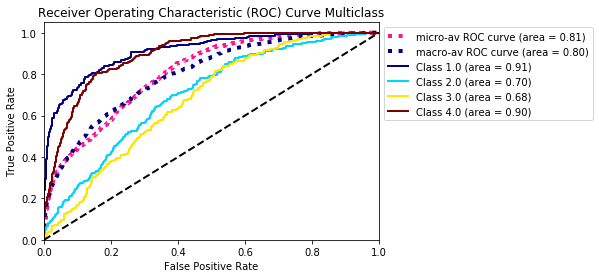

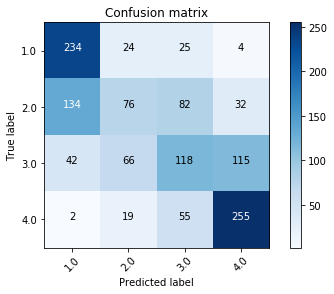

            Results
Accuracy   0.532346
Precision  0.504839
Recall     0.532346
F1         0.504716


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
#Implement classification method, per possession stats, decade 9
decade = 9
X = X_pm[X_pm['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']
rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: Per Minute\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scores_pm = cross_validate(clf, X, y, cv=50, scoring=scoring)




Logistic regression classifier: Per Possession



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


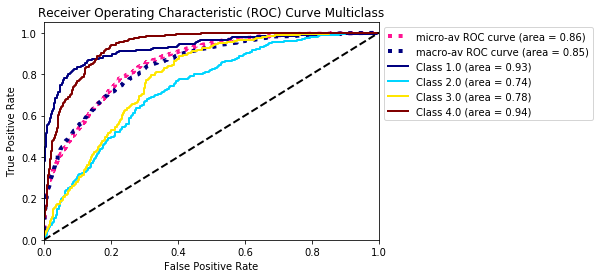

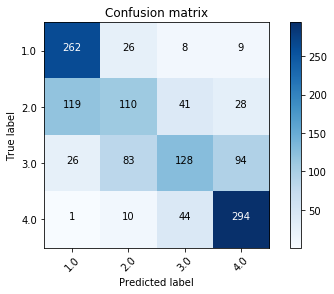

            Results
Accuracy   0.618862
Precision  0.601822
Recall     0.618862
F1         0.597968


In [22]:
#Implement classification method, per possession stats, decade 9
decade = 9
X = X_pp[X_pp['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']
rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: Per Possession\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scores_pp = cross_validate(clf, X, y, cv=50, scoring=scoring)




Logistic regression classifier: Advanced Stats



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


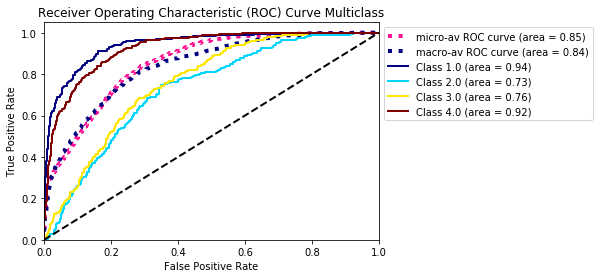

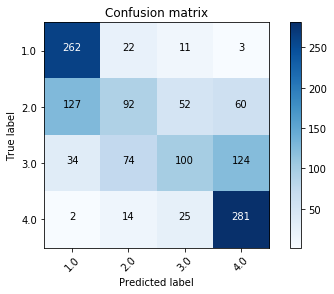

            Results
Accuracy   0.572876
Precision  0.549021
Recall     0.572876
F1         0.535468


In [23]:
#Implement classification method, per possession stats, decade 9
decade = 9
X = X_as[X_as['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']
rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: Advanced Stats\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_test, y_test, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr = clf.predict(X_test)#apply the model
aScore = accuracy_score(y_test, preds_logr)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_test, preds_logr)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_test, preds_logr, average='weighted')#get precision
R = recall_score(y_test, preds_logr, average='weighted')#get recall
F1 = f1_score(y_test, preds_logr, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scores_as = cross_validate(clf, X, y, cv=50, scoring=scoring)




Logistic regression classifier: All Stats



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


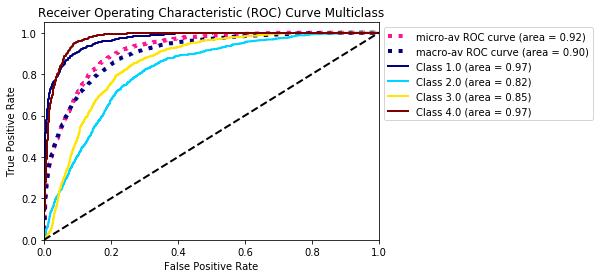

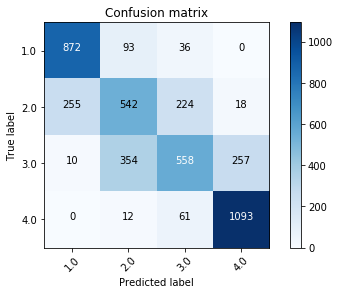

            Results
Accuracy   0.698974
Precision  0.686505
Recall     0.698974
F1         0.687307


Text(0.5, 0, 'Cross Validation Run')

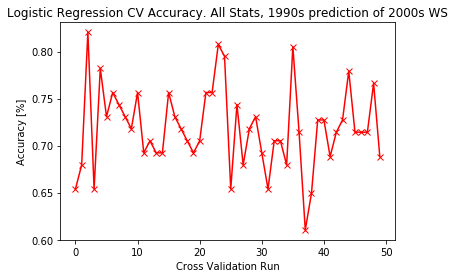

In [36]:
#Apply the best performing model.. to the next decade, and see how well it predicts the WS.
#Implement classification method, all stats, decade 9
decade = 9
X = X_e[X_e['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']

next_decade = 0
X_nd = X_e[X_e['Decade'] == next_decade]#pull out data for the 90s
cats_nd = stats_filt[stats_filt['Decade'] == next_decade].loc[:,'WS_class']

rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
classes_nd, y_nd = np.unique(cats_nd, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: All Stats\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_nd, y_nd, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr_e = clf.predict(X_nd)#apply the model
aScore = accuracy_score(y_nd, preds_logr_e)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_nd, preds_logr_e)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_nd, preds_logr_e, average='weighted')#get precision
R = recall_score(y_nd, preds_logr_e, average='weighted')#get recall
F1 = f1_score(y_nd, preds_logr_e, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores_9_0 = cross_validate(clf, X, y, cv=50, scoring=scoring)
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,len(scores_9_0['test_accuracy']),1).astype(int), scores_9_0['test_accuracy'], 'r-x')
ax.set_title('Logistic Regression CV Accuracy. All Stats, 1990s prediction of 2000s WS')
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Cross Validation Run')




Logistic regression classifier: All Stats



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


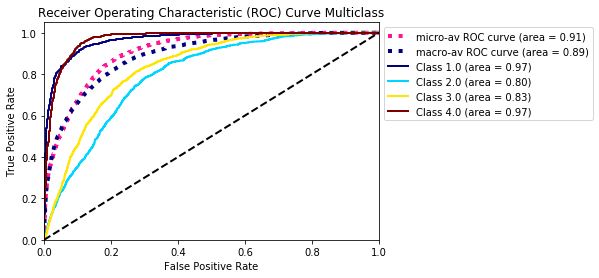

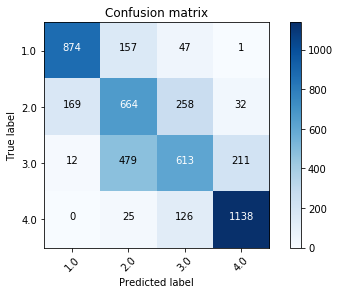

            Results
Accuracy   0.684353
Precision  0.684602
Recall     0.684353
F1         0.681406


Text(0.5, 0, 'Cross Validation Run')

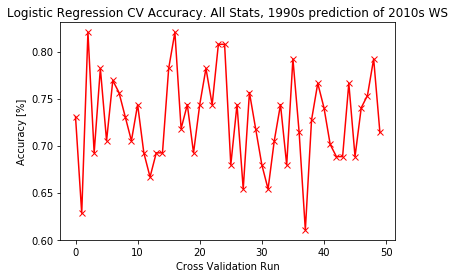

In [37]:
#Apply the best performing model.. to the next decade, and see how well it predicts the WS.
#Implement classification method, all stats, decade 9
decade = 9
X = X_e[X_e['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']

next_decade = 1
X_nd = X_e[X_e['Decade'] == next_decade]#pull out data for the 90s
cats_nd = stats_filt[stats_filt['Decade'] == next_decade].loc[:,'WS_class']

rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
classes_nd, y_nd = np.unique(cats_nd, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: All Stats\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_nd, y_nd, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr_e = clf.predict(X_nd)#apply the model
aScore = accuracy_score(y_nd, preds_logr_e)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_nd, preds_logr_e)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_nd, preds_logr_e, average='weighted')#get precision
R = recall_score(y_nd, preds_logr_e, average='weighted')#get recall
F1 = f1_score(y_nd, preds_logr_e, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores_9_1 = cross_validate(clf, X, y, cv=50, scoring=scoring)
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,len(scores_9_1['test_accuracy']),1).astype(int), scores_9_1['test_accuracy'], 'r-x')
ax.set_title('Logistic Regression CV Accuracy. All Stats, 1990s prediction of 2010s WS')
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Cross Validation Run')




Logistic regression classifier: All Stats



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


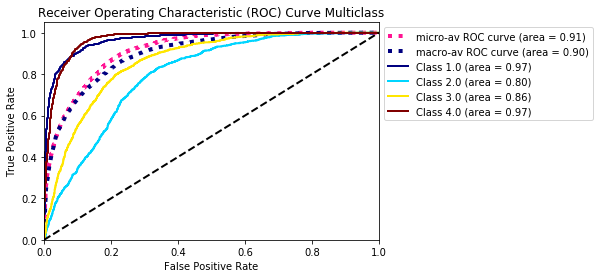

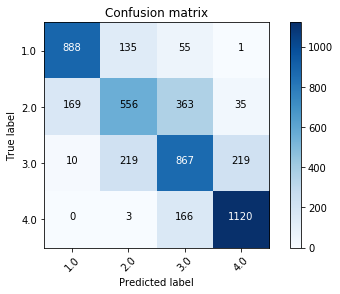

            Results
Accuracy   0.713899
Precision  0.711103
Recall     0.713899
F1         0.710472


Text(0.5, 0, 'Cross Validation Run')

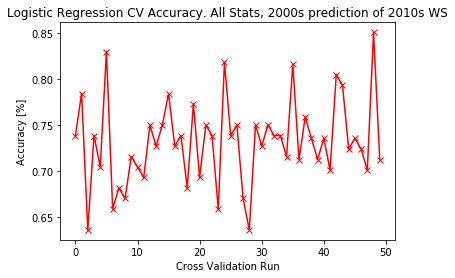

In [39]:
#Apply a logistic regression model built from 2000s data.. to the 2010s decade, and see how well it predicts the WS.
#Implement classification method, all stats
decade = 0
X = X_e[X_e['Decade'] == decade]#pull out data for the 90s
cats = stats_filt[stats_filt['Decade'] == decade].loc[:,'WS_class']

next_decade = 1
X_nd = X_e[X_e['Decade'] == next_decade]#pull out data for the 90s
cats_nd = stats_filt[stats_filt['Decade'] == next_decade].loc[:,'WS_class']

rs = random.seed(15)#set random seed
classes, y = np.unique(cats, return_inverse=True)#get unique class names and translate to integer values
classes_nd, y_nd = np.unique(cats_nd, return_inverse=True)#get unique class names and translate to integer values
#split into train and test dataframes for predictive modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=rs)

# Logistic regression classifier
print ('\n\n\nLogistic regression classifier: All Stats\n')
C_parameter = 50. / len(X_train) # parameter for regularization of the model
class_parameter = 'ovr' # parameter for dealing with multiple classes
penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
solver_parameter = 'saga' # optimization system used
tolerance_parameter = 0.1 # termination parameter
#####################

#setting up the model
clf = LogisticRegression(C=C_parameter, multi_class=class_parameter, 
                         penalty=penalty_parameter, solver=solver_parameter, 
                         tol=tolerance_parameter)

#function returns multiclass ROC plot with AUC scores per class
multiclassROC(X_train, y_train, X_nd, y_nd, clf, classes)
clf.fit(X_train, y_train)#training the model
preds_logr_e = clf.predict(X_nd)#apply the model
aScore = accuracy_score(y_nd, preds_logr_e)#get accuracy score
# Confusion Matrix
CM = confusion_matrix(y_nd, preds_logr_e)#create confusion matrix
plot_confusion_matrix(CM, classes)#plot of the multiclass confusion matrix
P = precision_score(y_nd, preds_logr_e, average='weighted')#get precision
R = recall_score(y_nd, preds_logr_e, average='weighted')#get recall
F1 = f1_score(y_nd, preds_logr_e, average='weighted')#get F1 score
a = {'Results': [aScore, P, R, F1]}# create series of evaluation metrics
aFrame_l = pd.DataFrame(a, index = ['Accuracy', 'Precision', 'Recall', 'F1'])
print(aFrame_l)#print series of evaluation metrics
#####################
#Cross Validation
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores_0_1 = cross_validate(clf, X, y, cv=50, scoring=scoring)
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(0,len(scores_0_1['test_accuracy']),1).astype(int), scores_0_1['test_accuracy'], 'r-x')
ax.set_title('Logistic Regression CV Accuracy. All Stats, 2000s prediction of 2010s WS')
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Cross Validation Run')